In [1]:
%reload_ext autoreload
%autoreload 2


In [15]:
import os
import glob
import json
from collections import defaultdict
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


charter_dir = '../data/charters/'

charter_files = glob.glob(os.path.join(charter_dir, '**/*.json'))
len(charter_files)

5955

## Reading Charters from file

The charters are stored as lists of word tokens, with per token a range of word forms (*original* spelling in the document, *lowercase*, *full* spelling without abbreviation, and *lemma*) and part-of-speech information.

#### Sentences and clause boundaries

Tokens also contain information on whether they are the start of a sentence or clausal unit within a sentence. 

**We assume that formulas are syntactically constraint by sentence boundaries**, so we look for formulaic expressions with sentences.

Below the first sentence of a charter is shown in three different representations.

In [3]:
from scripts.read import CharterReader

charters_orig = CharterReader(charter_files, 'orig', as_sentences=True)
charters_full = CharterReader(charter_files, 'full', as_sentences=True)
charters_lemma = CharterReader(charter_files, 'lemma', as_sentences=True)

for charter in charters_orig:
    print(charter['charter_id'], '\n')
    print(f"\t{' '.join(charter['words'])}\n")
    break

for charter in charters_full:
    print(f"\t{' '.join(charter['words'])}\n")
    break

for charter in charters_lemma:
    print(f"\t{' '.join(charter['words'])}\n")
    break


_o_K094p35502.GADordrecht1.Inv99a.Reg237 

	WJ broeder alaerd van dieden ghardiaen van den minrebroedren in dordr_ en_ broeder ghisebrecht van den berghe lesemeester ter minrebroedren vors_ maken kont en_ kenlic allen luden dat wi ghesien en_ ghehoert hebbe_ jn ons he_en jaer M&r; ccc&r; viue en_ vijftic des donredaghes na sinte jans dach te midde~zomer Een brief ghans en_ ghaue wel bezeghelt Met ons liefs he_en . tsgrauen zeghel van holl_t jn desen worden als hier~na ghescreuen staed &unreadable;

	wj broeder alaerd van dieden ghardiaen van den minrebroedren in dordrecht ende broeder ghisebrecht van den berghe lesemeester ter minrebroedren vorseit maken kont ende kenlic allen luden dat wi ghesien ende ghehoert hebben jn ons heeren jaer m ccc viue ende vijftic des donredaghes na sinte jans dach te middezomer een brief ghans ende ghaue wel bezeghelt met ons liefs heeren . tsgrauen zeghel van hollant jn desen worden als hierna ghescreuen staed &unreadable;

	wij broeder adelhard van died

The words with underscores in the first representation are abbreviated words that are fully spelled out in the second representation.

## Extracting Formulaic Phrases

In the next step, we iterate over all charters and look for word sequences that occur frequently. We take an arbitrary frequency threshold of 100 and ignore:

- all word sequences containing a word that falls below the frequency threshold, and 
- all word sequences containing pairs of words with a co-occurrence frequency (within a window of 5 words) below that threshold.

In [4]:
from formula_detection.search import FormulaSearch

charter_full_search = FormulaSearch(charters_full, min_term_freq=100)
charter_full_search.calculate_co_occurrence_frequencies()

Iterating over sentences to calculate term frequencies
full collection size (tokens): 2116206
full lexicon size (types): 89459
minimum term frequency: 100
minimum frequency lexicon size: 1934
No value passed for min_cooc_freq, skipping co-occurrence calculations.
Iterating over sentences to calculate the co-occurrence frequencies
co-occurence index size: 585529


In [5]:
for pi, candidate_phrase_match in enumerate(charter_full_search.extract_phrases_from_sents(phrase_type='long_phrases', 
                                                                                      min_cooc_freq=100,
                                                                                      max_variables=0)):
    
    print(candidate_phrase_match.word_start, '\t', candidate_phrase_match.candidate_phrase.phrase_string)
    if (pi+1) % 10 == 0:
        break
        


Minimum co-occurrence frequency: 100
9 	 in dordrecht ende broeder ghisebrecht van den berghe
20 	 vorseit maken kont ende kenlic allen luden dat wi
32 	 hebben jn ons heeren jaer m ccc viue ende
44 	 na sinte jans dach te
55 	 wel bezeghelt met ons liefs heeren .
63 	 zeghel van hollant jn desen
6 	 hebben in kennessen der waerheyt onse zeghele ghehanghen an dit
18 	 jnt jaer ons heeren
23 	 als wi desen vorscreuen brief
6 	 sone scepene jn


These are the first ten word sequences of words that occur at least 100 times by themselves and co-occur with the other words in the phrase at least 100 times. 

To find frequent word sequences, we limit phrases to 5 words and count all partially overlapping 5-word phrases. To illustrate, the first phrase above, `in dordrecht ende broeder ghisebrecht van den berghe` is turned into the following four 5-word phrases:

- `in dordrecht ende broeder ghisebrecht`
- `dordrecht ende broeder ghisebrecht van`
- `ende broeder ghisebrecht van den`
- `broeder ghisebrecht van den berghe`


In [6]:
from scripts.extract import get_candidate_phrases
import scripts.extract as extract

max_matches = 1e6

candidate_phrase_matches, overlap = get_candidate_phrases(charter_full_search, max_matches, 
                                                          phrase_type='sub_phrases', 
                                                          min_cooc_freq=100, max_phrase_length=5, 
                                                          max_variables=1)

candidate_phrase_freq = Counter([cm.candidate_phrase.phrase_string for cm in candidate_phrase_matches])


Minimum co-occurrence frequency: 100
allen den ghenen die dese                              597
ons heren dusent drie hondert                          542
dit was ghedaen jnt jaer                               496
. m . ccc .                                            491
allen den goenen die dese                              463
doen te wetene allen den                               459
den goenen die dese lettren                            445
ons heren als men screef                               440
was ghedaen jnt jaer ons                               440
jaer ons heren als men                                 401


In [ ]:
print(f"\n{'Formulaic phrase': <50}{'Frequency': >10}")
print('------------------------------------------------------------')
for candidate_phrase, freq in candidate_phrase_freq.most_common(10):
    print(f"{candidate_phrase: <50}{freq: >10}")

### Mapping spelling variants

Below is a quick and dirty (and error-prone) approach to mapping some spelling variants onto a single representation. This is based on partially overlapping phrases.

For instance, the phrase `allen den ghenen die dese` is found 597 times, and partially overlaps with the phrases:
- `den ghenen die dese lettere`
- `den ghenen die dese lettre`
- `den ghenen die dese letteren`
- `den ghenen die dese brief`

In all cases above, the first four words overlap with `allen den ghenen die dese`, and the last word follows it. The first three cases are spelling variants (*lettere*, *lettre* and *letteren*), while *brief* is a different word. Using the fact that these variants appear in the same positions in phrases that partially overlap with a frequent phrase, we can algorithmically identify spelling variants.

In [8]:
from collections import Counter

word_freq = Counter()

for charter in charters_full:
    word_freq.update([word for word in charter['words']])

for word, freq in word_freq.most_common(10):
    print(word, freq)

ende 115972
van 75037
, 66298
. 50023
die 40397
~ 37050
dat 35876
den 32912
te 31552
in 22040


In [9]:
from fuzzy_search.similarity import SkipgramSimilarity

from scripts.fuzzy import cluster_similar_phrases
from scripts.fuzzy import map_word_variants

#cluster_similar_phrases(candidate_phrase_freq)

map_to = map_word_variants(candidate_phrase_freq, overlap, word_freq)
map_to

{'jnt': 'int',
 'sullen': 'zullen',
 'solen': 'zullen',
 'sien': 'sinen',
 'lettre': 'lettren',
 'letteren': 'lettren',
 'lettere': 'lettren',
 'acht': 'achte',
 'seuen': 'zeuen',
 'twe': 'twee',
 'tneghentich': 'neghentich',
 'tachtentich': 'neghentich',
 'ses': 'sesse',
 'zesse': 'sesse',
 'tseuentich': 'tsestich',
 'onse': 'ons',
 'neghene': 'neghen',
 'en': 'een',
 'viere': 'vier',
 'ghoenen': 'ghenen',
 'goenen': 'ghenen',
 'gonen': 'ghenen',
 'dusentech': 'dusentich',
 'sin': 'siin',
 'sine': 'sinen',
 'heeren': 'heren',
 'alse': 'als',
 'doe': 'doen',
 'soelen': 'zullen',
 'zelen': 'selen',
 'oft': 'ofte',
 'tsiaers': 'siaers',
 'desen': 'dese',
 'ij': 'iij',
 'camen': 'men',
 'quamen': 'quam',
 'ghezeghelt': 'bezeghelt',
 'yseghelt': 'bezeghelt',
 'gheseghelt': 'bezeghelt',
 'beseghelt': 'bezeghelt',
 'dies': 'die',
 'al': 'alle',
 'enen': 'een',
 'siars': 'siaers',
 'vlaemscher': 'vlaemsche',
 'iiij': 'iij',
 'vichtich': 'tachtich',
 'neghentech': 'neghentich',
 'here': 'heren

### Rewrite variants to single orthography

We can add these word variant mappings to the Charter reader, so that it returns charters as word lists, with the spelling variants mapped.

In [10]:
charters_norm = CharterReader(charter_files, 'full', as_sentences=True, rewrite_map=map_to)
charter_norm_search = FormulaSearch(charters_norm, min_term_freq=100)
charter_norm_search.calculate_co_occurrence_frequencies()

Iterating over sentences to calculate term frequencies
full collection size (tokens): 2116206
full lexicon size (types): 89378
minimum term frequency: 100
minimum frequency lexicon size: 1853
No value passed for min_cooc_freq, skipping co-occurrence calculations.
Iterating over sentences to calculate the co-occurrence frequencies
co-occurence index size: 530708


In [11]:
candidate_phrase_matches, overlap = get_candidate_phrases(charter_norm_search, max_matches, 
                                                          phrase_type='sub_phrases', 
                                                          min_cooc_freq=100, max_phrase_length=5, 
                                                          max_variables=1)

candidate_phrase_freq = Counter([cm.candidate_phrase.phrase_string for cm in candidate_phrase_matches])

Minimum co-occurrence frequency: 100


In [12]:
print(f"\n{'Formulaic phrase': <50}{'Frequency': >10}")
print('------------------------------------------------------------')
for candidate_phrase, freq in candidate_phrase_freq.most_common(10):
    print(f"{candidate_phrase: <50}{freq: >10}")


Formulaic phrase                                   Frequency
------------------------------------------------------------
alle den ghenen die dese                                1830
den ghenen die dese lettren                             1438
ghenen die dese lettren zullen                          1145
die dese lettren zullen zien                             834
dese lettren bezeghelt met onsen                         806
ghedaen int jaer ons heren                               737
dit was ghedaen int jaer                                 709
ons heren als men screef                                 656
was ghedaen int jaer ons                                 634
lettren bezeghelt met onsen zeghelen                     611


### Position of Common Phrases in Charter

We look at the relative start and end positions of phrases within charters. Some tend to occur near the start of a charter, others near the middle or end, and yet other have no positional tendency.

The position tells us something about the function or type of a phrase.

To determine the relative position of a phrase in a charter, we need to calculate the length of each charter in number of words.

In [13]:
from collections import defaultdict

doc_length = defaultdict(int)
for charter in charters_lemma:
    doc_length[charter['charter_id']] += len(charter['words'])
    
print(f'Number of charters: {len(doc_length)}')

Number of charters: 5942


In [26]:
match_data = extract.make_matches_dict(candidate_phrase_matches, doc_length)

phrases = pd.DataFrame(match_data)

phrases['freq'] = phrases.phrase.apply(lambda x: candidate_phrase_freq[x])

phrases.sort_values('freq', ascending=False).head(10)

,doc_id,doc_length,phrase,start_offset,end_offset,rel_start,rel_end,freq
534488,_c_GrHol29101_n:1299.HANDBnr1809a,485,alle den ghenen die dese,21,26,0.043299,0.946392,1830
592188,_o_H036p28954,169,alle den ghenen die dese,41,46,0.242604,0.727811,1830
770123,_o_O061p30001,358,alle den ghenen die dese,1,6,0.002793,0.983240,1830
525779,_o_K160p28902,346,alle den ghenen die dese,21,26,0.060694,0.924855,1830
482486,_o_H036p28608,260,alle den ghenen die dese,17,22,0.065385,0.915385,1830
82422,_o_N141p36602.RAKortrijkStMaartens.41,343,alle den ghenen die dese,35,40,0.102041,0.883382,1830
557887,_o_H036p28832,303,alle den ghenen die dese,48,53,0.158416,0.825083,1830
374457,_o_N141p35701.RAKortrijkBlauweNummers.335,369,alle den ghenen die dese,31,36,0.084011,0.902439,1830
660526,_o_I241p30003,210,alle den ghenen die dese,5,10,0.023810,0.952381,1830
380062,_o_H036p29906,434,alle den ghenen die dese,48,53,0.110599,0.877880,1830


There are many different formulaic phrases. For a first impression, we focus on the most common phrases, that occur more than 500 times.

In [39]:
s = phrases.phrase.value_counts()
common_phrases = phrases[phrases.phrase.isin(s[s > 500].index)]
common_phrases.phrase.value_counts()

alle den ghenen die dese                1830
den ghenen die dese lettren             1438
ghenen die dese lettren zullen          1145
die dese lettren zullen zien             834
dese lettren bezeghelt met onsen         806
ghedaen int jaer ons heren               737
dit was ghedaen int jaer                 709
ons heren als men screef                 656
was ghedaen int jaer ons                 634
lettren bezeghelt met onsen zeghelen     611
doen te wetene alle den                  596
int jaer ons heren als                   595
jaer ons heren als men                   595
ghegheuen int jaer ons heren             583
ons heren dusent drie hondert            560
te wetene alle den ghenen                534
wetene alle den ghenen die               532
int jaer ons heren dusent                520
Name: phrase, dtype: int64

In the table above, the formulaic expression `alle den ghenen die dese` appears near the start of a charter.

The relative start position `rel_start` is calculated as the `start_offset` divided by the `doc_length`. We can group all phrases by creating mapping each relative start value to one of five bins, e.g. 0%-20%, 20%-40%, 40%-60%, 60%-80% and 80%-100% of the charter. That way we can aggregate occurrences with similar positions. 

In [30]:
factor = 5
phrases['start_bin'] = phrases.rel_start.apply(lambda x: int(x*factor)/factor)
phrases['end_bin'] = phrases.rel_end.apply(lambda x: int(x*factor)/factor)


In [40]:
common_phrases.groupby('phrase').start_bin.describe().sort_values('50%')


,count,mean,std,min,25%,50%,75%,max
phrase,,,,,,,,
alle den ghenen die dese,1830.0,0.015956,0.059219,0.0,0.0,0.0,0.0,0.8
te wetene alle den ghenen,534.0,0.018352,0.062771,0.0,0.0,0.0,0.0,0.6
ons heren dusent drie hondert,560.0,0.016786,0.076158,0.0,0.0,0.0,0.0,0.8
ons heren als men screef,656.0,0.229268,0.359300,0.0,0.0,0.0,0.8,0.8
jaer ons heren als men,595.0,0.261849,0.371647,0.0,0.0,0.0,0.8,0.8
int jaer ons heren dusent,520.0,0.039615,0.165316,0.0,0.0,0.0,0.0,0.8
int jaer ons heren als,595.0,0.258151,0.370885,0.0,0.0,0.0,0.8,0.8
was ghedaen int jaer ons,634.0,0.228391,0.359500,0.0,0.0,0.0,0.8,0.8
ghenen die dese lettren zullen,1145.0,0.035459,0.081294,0.0,0.0,0.0,0.0,0.8


The `50%` column shows the bin of the 50th percentile, in other words, the _median_ start position of a phrase. 

Most of these phrases mostly fall in the first bin ($0.0$, that is, a start position between 0% and 20). In other words, they appear near the start. However, the bottom two phrases fall in the $0.8$ bin (80%-100%), meaning they tend to occur near the end of a charter.

### Bi-modal phrases

In the middle, there are a few phrases for which the median occurrence is in the first bin ($0.0$) but the 75th percentile is 0.8 or 0.6 (e.g. `ons heren als men screef` and `ghedaen int jaer ons heren`). The majority of these phrases appear near the start, but at least 25% of them appear near the end. It seems they occur in multiple contexts.

We'll refer to these phrases as bi-modal phrases. We analyse these phrases separately.

In [41]:
g = common_phrases.groupby('phrase').start_bin.describe().sort_values('50%')
uni_modal_phrases = common_phrases[common_phrases.phrase.isin(g[g['75%'] <= 0.5].index)]
bi_modal_phrases = common_phrases[common_phrases.phrase.isin(g[g['75%'] > 0.5].index)]


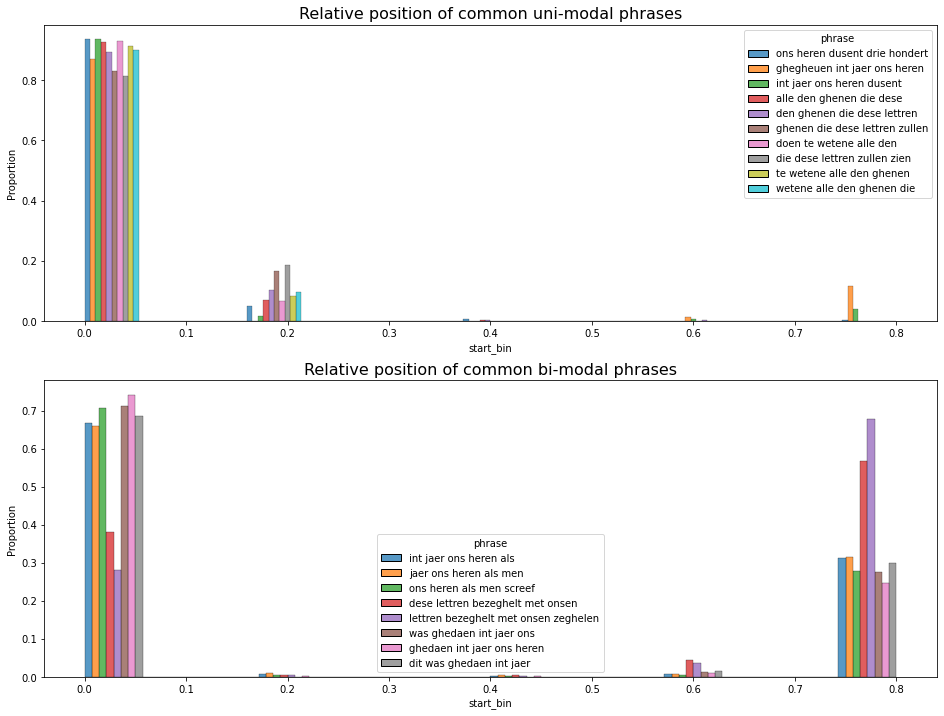

In [49]:
fig, ax = plt.subplots(2, 1)

sns.histplot(data=uni_modal_phrases, x='start_bin', hue='phrase', multiple='dodge', ax=ax[0], stat='proportion', common_norm=False)

sns.histplot(data=bi_modal_phrases, x='start_bin', hue='phrase', multiple='dodge', ax=ax[1], stat='proportion', common_norm=False)

ax[0].set_title('Relative position of common uni-modal phrases', fontsize=16)
ax[1].set_title('Relative position of common bi-modal phrases', fontsize=16)
fig.set_size_inches(16,12)


The phrases `dese lettren bezeghelt met onsen` and `lettren bezeghelt met onsen zeghelen` (which are partially overlapping with each other) are more common at the end, while the other bi-modal phrases are more common at the start. 


### Phrases and the length of Charters

We can also see of phrases are associated with the length of Charters. That is, do some phrases tend to occur in long or short charters?

In [32]:
common_phrases.groupby('phrase').doc_length.describe()


,count,mean,std,min,25%,50%,75%,max
phrase,,,,,,,,
alle den ghenen die dese,1830.0,321.460656,244.011101,72.0,193.00,257.0,377.75,4198.0
den ghenen die dese lettren,1438.0,308.577191,207.165486,72.0,192.00,252.0,355.75,2117.0
dese lettren bezeghelt met onsen,806.0,333.002481,254.927675,91.0,207.00,266.5,356.00,2312.0
die dese lettren zullen zien,834.0,306.661871,215.208385,72.0,188.00,241.0,332.75,2117.0
dit was ghedaen int jaer,709.0,348.308886,347.719864,55.0,210.00,279.0,394.00,5347.0
doen te wetene alle den,596.0,313.921141,205.570709,72.0,200.00,261.0,348.25,2117.0
ghedaen int jaer ons heren,737.0,346.972863,342.077567,55.0,214.00,275.0,390.00,5347.0
ghegheuen int jaer ons heren,583.0,285.228130,176.206224,75.0,167.00,235.0,342.50,1442.0
ghenen die dese lettren zullen,1145.0,288.607860,198.307425,72.0,185.00,237.0,310.00,2117.0


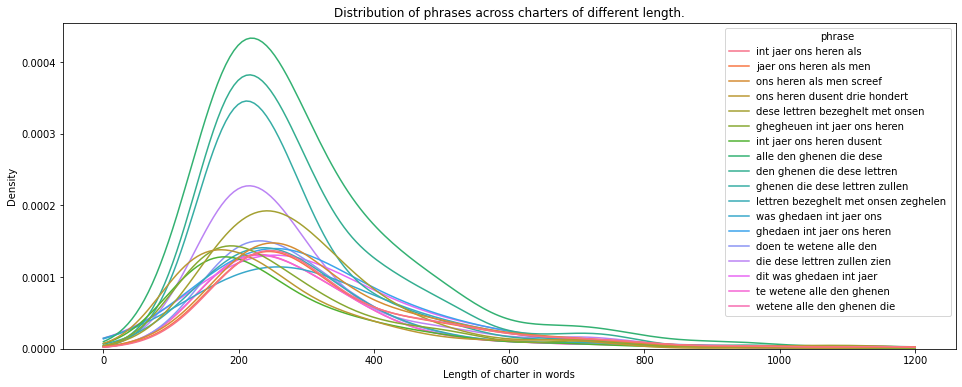

In [54]:
ax = sns.kdeplot(data=common_phrases, x='doc_length', hue='phrase', clip=(0, 1200));

ax.set_title('Distribution of phrases across charters of different length.')
ax.set_xlabel('Length of charter in words')
ax.figure.set_size_inches(16,6)

## Clustering partially overlapping phrases

Above we saw that many phrases partially overlap with each other. If two partially overlapping phrases almost always overlap, that is a signal that they are part of a single formulaic expression. We use overlap statistics to determine which overlapping phrases should be considered part of the same formulaic expressions, which cases should be considered as one phrase being a qualification of the other and which cases are only incidentally overlapping. 

### Extending Phrases to Formulas

We consider the following classes for overlapping phrases:

- **Formulaic expression**: a phrase that is not overlapping with anything more frequent than itself.
- **Extension**: a phrase that almost always overlaps with a _formulaic expression_ that is slightly more frequent than itself (at least 75% of occurrences of the extension overlap with the _formulaic expression_). In these cases, the extension and the formulaic expression are both part of a single formula.
- **Qualification**: a phrase that almost always overlaps with a formula that is significantly more frequent than itself (fewer than 75% of occurrences overlap with the _formulaic expression_). In these cases, the phrase is a specific case of the general formula.


In [55]:
overlap_data = extract.make_overlap_dict(candidate_phrase_freq, overlap)
formula_clusters, clustered = extract.cluster_overlapping_phrases(candidate_phrase_freq, overlap)

In [61]:
print(f"{'MAIN_PHRASE': <35}{'Freq': >6}\t{'FORMULA': <35}")
print('-----------------------------------------------------------------------------------------------')

for cluster in formula_clusters:
    max_right_dist = 0
    max_left_dist = 0
    max_right_phrase = None
    max_left_phrase = None

    main_phrase = cluster['core']['phrase']
    formula = main_phrase
    main_freq = candidate_phrase_freq[cluster['core']['phrase']]
    for phrase_info in cluster['extension']:
        phrase_freq = candidate_phrase_freq[phrase_info['phrase']]
        if phrase_info['dist'] > 0:
            if phrase_info['dist'] > max_right_dist:
                max_right_dist = phrase_info['dist']
                max_right_phrase = phrase_info['phrase']
        else:
            if phrase_info['dist'] < max_left_dist:
                max_left_dist = phrase_info['dist']
                max_left_phrase = phrase_info['phrase']
    if max_right_dist > 0:
        extra_right_words = max_right_phrase.split(' ')[-max_right_dist:]
        formula = f"{formula} {' '.join(extra_right_words)}"
    if max_left_dist < 0:
        extra_left_words = max_left_phrase.split(' ')[:-max_left_dist]
        formula = f"{' '.join(extra_left_words)} {formula}"
    print(f"{main_phrase: <35}{main_freq: >6}\t{formula}")


MAIN_PHRASE                          Freq	FORMULA                            
-----------------------------------------------------------------------------------------------
alle den ghenen die dese             1830	alle den ghenen die dese lettren
dese lettren bezeghelt met onsen      806	dese lettren bezeghelt met onsen
ghedaen int jaer ons heren            737	dit was ghedaen int jaer ons heren
ons heren als men screef              656	jaer ons heren als men screef
ghegheuen int jaer ons heren          583	ghegheuen int jaer ons heren
ons heren dusent drie hondert         560	ons heren dusent drie hondert
. m . ccc .                           491	. m . ccc .
int jaer ons heren m                  363	int jaer ons heren m
int jaer ons heren .                  343	int jaer ons heren .
ons heren doen men screef             332	ons heren doen men screef
lettren zullen zien jof horen         326	ghenen die dese lettren zullen zien jof horen lesen
~ v ~ 't3s ~                          285	

het ne ware dat die                    10	het ne ware dat die
ende niet min die wille                10	ende niet min die wille
te wetene dat elc mensche              10	te wetene dat elc mensche
sal verbueren ~ x ~                    10	hie sal verbueren ~ x ~
van elken <VAR> ~ iij                  10	van elken <VAR> ~ iij ~
ende die hem niet dar                  10	ende die hem niet dar
~ elnen lanc diese <VAR>               10	~ elnen lanc diese <VAR>
~ vierendeel breet ende ~              10	~ vierendeel breet ende ~
~ i ~ <VAR> min                        10	~ i ~ <VAR> min
~ elnen lanc , ende                    10	~ elnen lanc , ende
ende met ~ i ~                         10	<VAR> ende met ~ i ~
~ 't3s ~ ende dat                      10	~ 't3s ~ ende dat
dese vorseide ~ iij ~                  10	dese vorseide ~ iij ~
also alst vorseid es ,                 10	also alst vorseid es ,
~ iij ~ iaer ende                      10	<VAR> ~ iij ~ iaer ende
<VAR> sal hebben die graue         

In [62]:
phrase_types = [
    'extension', 
    'qualification', 
    #'variable'
]

for cluster in formula_clusters:
    main_phrase = cluster['core']['phrase']
    main_freq = candidate_phrase_freq[cluster['core']['phrase']]
    print(f"{main_freq: >6}\t\t{main_phrase: <25}")
    for phrase_type in phrase_types:
        for phrase_info in cluster[phrase_type]:
            phrase_freq = candidate_phrase_freq[phrase_info['phrase']]
            if phrase_info['dist'] > 0:
                overlap_freq = overlap[main_phrase][phrase_info['dist']][phrase_info['phrase']]
            else:
                overlap_freq = overlap[phrase_info['phrase']][-phrase_info['dist']][main_phrase]
            if overlap_freq <= 2:
                continue
            indent = '\t' * abs(phrase_info['dist'])
            freq_tup = f"({phrase_freq},{overlap_freq},{phrase_info['dist']})"
            print(f"{freq_tup: <16}\t{indent}{phrase_info['phrase']: <40}{phrase_type}")
    print('\n')

  1830		alle den ghenen die dese 
(1438,1403,1)   		den ghenen die dese lettren             extension
(277,276,1)     		den ghenen die dese brief               qualification
(16,15,1)       		den ghenen die dese ten                 qualification
(1145,985,2)    			ghenen die dese lettren zullen          qualification
(315,311,2)     			ghenen die dese lettren selen           qualification
(63,60,2)       			ghenen die dese brief <VAR>             qualification
(31,30,2)       			ghenen die dese brief selen             qualification
(68,65,2)       			ghenen die dese lettren sinen           qualification
(147,137,2)     			ghenen die dese brief zullen            qualification
(16,14,2)       			ghenen die dese <VAR> lettren           qualification
(26,23,2)       			ghenen die dese lettren zien            qualification
(7,7,2)         			ghenen die dese <VAR> selen             qualification
(16,15,2)       			ghenen die dese ten rechte              qualification
(47,38,2)       			ghene

(9,9,-1)        		<VAR> zeghelen int jaer ons             qualification


    87		land te wetten te waerne 
(10,8,2)        			wetten te waerne met <VAR>              qualification
(48,43,-2)      			ende quite land te wetten               qualification
(7,7,-2)        			& quite land te wetten                  qualification
(40,32,-1)      		vorseide land te wetten te              qualification
(52,51,-1)      		quite land te wetten te                 qualification


    87		wie scepenen vanden vrien doen
(4,4,-3)        				<VAR> die weuel wie scepenen            qualification
(5,4,-3)        				gherard die weuel wie scepenen          qualification
(4,4,-2)        			heinemans . wie scepenen vanden         qualification
(9,9,-2)        			die weuel wie scepenen vanden           qualification
(8,8,-2)        			van <VAR> wie scepenen vanden           qualification
(3,3,-2)        			jan mont wie scepenen vanden            qualification
(6,5,-2)        			jan <VAR> wie scepenen vanden

(5,4,1)         		drie hondert neghentich ende <VAR>      qualification
(6,6,1)         		drie hondert neghentich ende drie       qualification
(6,6,1)         		drie hondert neghentich ende vier       qualification
(5,5,1)         		drie hondert neghentich ende een        qualification
(3,3,1)         		drie hondert neghentich ende ene        qualification
(5,5,2)         			hondert neghentich ende neghen opten    qualification
(3,3,2)         			hondert neghentich ende een ,           qualification
(3,3,2)         			hondert neghentich ende <VAR> op        qualification
(3,3,2)         			hondert neghentich ende drie op         qualification
(3,3,2)         			hondert neghentich ende ene opten       qualification
(5,4,-1)        		, dusent drie hondert neghentich        qualification
(18,15,-1)      		heren dusent drie hondert neghentich    qualification
(6,6,-1)        		<VAR> dusent drie hondert neghentich    qualification
(17,13,-1)      		screef dusent drie hondert neghentich   q

(10,9,2)        			, lighen bi dat ,                       qualification
(9,8,3)         				lighen bi dat , ende                    qualification
(9,8,4)         					bi dat , ende siin                      qualification


    25		huus ende erue staende ende
(6,6,1)         		ende erue staende ende gheleghen        qualification
(19,18,1)       		ende erue staende ende ligghende        qualification
(5,4,2)         			erue staende ende ligghende bin         qualification
(3,3,2)         			erue staende ende ligghende <VAR>       qualification
(3,3,2)         			erue staende ende ligghende jn          qualification
(3,3,3)         				staende ende ligghende <VAR> der        qualification
(3,3,-1)        		een huus ende erue staende              qualification


    25		ghegheuen dese <VAR> na sinte


    25		dusentich , drie hondert ,


    25		ons heren dat men screef 
(10,10,1)       		heren dat men screef dusentich          qualification
(5,5,1)         		heren dat men screef ~      



    18		als heren van den gronde 
(5,4,1)         		heren van den gronde <VAR>              qualification
(4,4,-1)        		, als heren van den                     qualification


    18		scepenen jn der goude <VAR>
(6,6,-1)        		soene scepenen jn der goude             qualification
(3,3,-1)        		soen scepenen jn der goude              qualification
(3,3,-1)        		sone scepenen jn der goude              qualification


    18		, van der ordenen van    
(3,3,-3)        				<VAR> van breda , van                   qualification
(3,3,-2)        			van breda , van der                     qualification
(4,4,-1)        		breda , van der ordenen                 qualification
(6,6,-1)        		<VAR> , van der ordenen                 qualification


    18		den voerseide heren van heere
(6,6,1)         		voerseide heren van heere in            qualification
(3,3,1)         		voerseide heren van heere van           qualification
(3,3,2)         			heren van heere van den             

(5,5,3)         				van vinders als van dien                qualification
(4,4,3)         				van vinders hie verbuerde van           qualification
(4,4,4)         					vinders hie verbuerde van elken         qualification
(4,4,-3)        				hie <VAR> si van deken                  qualification
(4,4,-3)        				ware bi <VAR> van deken                 qualification
(4,4,-2)        			<VAR> si van deken ende                 qualification
(4,4,-2)        			bi <VAR> van deken ende                 qualification
(3,3,-2)        			bi kennessen van deken ende             qualification
(4,4,-1)        		si van deken ende van                   qualification
(4,4,-1)        		<VAR> van deken ende van                qualification
(3,3,-1)        		kennessen van deken ende van            qualification
(4,4,-4)        					dat hie <VAR> si van                    qualification


    14		dese vorseide dinghe ende elke
(9,8,1)         		vorseide dinghe ende elke <VAR>         qualification
(4,4,-



    11		waren die scepen te <VAR>
(5,5,-1)        		hierouer waren die scepen te            qualification


    11		van den vorseide huus ende
(9,9,1)         		den vorseide huus ende erue             extension
(5,5,-1)        		, van den vorseide huus                 qualification
(3,3,-1)        		rechte van den vorseide huus            qualification


    11		gheen <VAR> van rechte achterghelaten
(25,9,-2)       			, ende gheen <VAR> van                  extension
(26,10,-1)      		ende gheen <VAR> van rechte             extension
(4,4,1)         		<VAR> van rechte achterghelaten .       qualification
(4,4,1)         		<VAR> van rechte achterghelaten ,       qualification


    11		<VAR> dat voer ons quam  
(3,3,-1)        		scepenen <VAR> dat voer ons             qualification


    11		, ende <VAR> , die       


    11		drie hondert <VAR> ende achte
(7,7,1)         		hondert <VAR> ende achte op             qualification


    11		van den dorpe van <VAR>  
(3,3,1)         		den 


    10		bunre ende <VAR> ruden ende


    10		, woren bruder <VAR> van 
(9,9,-1)        		lants , woren bruder <VAR>              extension


    10		woren bruder willems van der
(8,8,-1)        		, woren bruder willems van              extension
(3,3,1)         		bruder willems van der <VAR>            qualification
(5,5,-2)        			lants , woren bruder willems            qualification


    10		~ ende i d ~             
(9,9,-1)        		s ~ ende i d                            extension
(7,7,1)         		ende i d ~ ende                         qualification
(6,6,2)         			i d ~ ende ii                           qualification
(6,6,-2)        			ii s ~ ende i                           qualification


    10		ende x rop , lighen      
(9,9,-1)        		ruden ende x rop ,                      extension
(3,3,1)         		x rop , lighen bi                       qualification


    10		<VAR> ende ii d ~        
(4,4,-1)        		vor <VAR> ende ii d                     qualification



In [63]:
import pandas as pd

overlap_df = pd.DataFrame(overlap_data)
overlap_df

,phrase1,freq1,dist,phrase2,freq2,overlap_freq
0,alle den ghenen die dese,1830,1,den ghenen die dese lettren,1438,1403
1,alle den ghenen die dese,1830,1,den ghenen die dese presente,75,47
2,alle den ghenen die dese,1830,1,den ghenen die dese brief,277,276
3,alle den ghenen die dese,1830,1,den ghenen die dese <VAR>,88,44
4,alle den ghenen die dese,1830,1,den ghenen die dese ten,16,15
...,...,...,...,...,...,...
2238,lettren bezeghelt met onsen zeghelen,611,4,"zeghelen , met onsen lieuen",1,1
2239,lettren bezeghelt met onsen zeghelen,611,4,"zeghelen , ende met onsen",1,1
2240,lettren bezeghelt met onsen zeghelen,611,4,"zeghelen in kennessen , ende",1,1
2241,lettren bezeghelt met onsen zeghelen,611,4,zeghelen dit was ghedaen ende,3,1


In [64]:
overlap_df[overlap_df.phrase1 == 'alle den ghenen die dese'].sort_values('phrase2')


,phrase1,freq1,dist,phrase2,freq2,overlap_freq
7,alle den ghenen die dese,1830,1,"den ghenen die dese ,",1,1
3,alle den ghenen die dese,1830,1,den ghenen die dese <VAR>,88,44
2,alle den ghenen die dese,1830,1,den ghenen die dese brief,277,276
0,alle den ghenen die dese,1830,1,den ghenen die dese lettren,1438,1403
5,alle den ghenen die dese,1830,1,den ghenen die dese openen,1,1
...,...,...,...,...,...,...
24,alle den ghenen die dese,1830,2,ghenen die dese openen brief,1,1
11,alle den ghenen die dese,1830,2,ghenen die dese presente lettren,75,47
23,alle den ghenen die dese,1830,2,ghenen die dese ten rechte,16,15
27,alle den ghenen die dese,1830,2,ghenen die dese to rechte,1,1
